In [ ]:
import torch, torchvision, PIL, numpy as np
import pathlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.auto import tqdm
import pandas as pd
from google.colab import drive
import shutil

Get images and data. Relevant files are found in the respository except the images, which are found here: https://drive.google.com/file/d/1-0yYrZAs-BoonZeXHhS5Cb5jWHzlNFvK/view?usp=sharing.

In [ ]:
drive.mount('/content/drive')
with open(f'/content/drive/My Drive/CPEN 291 Datasets/Sports_Dataset/annotations_with_bbox.csv', 'r'):
  shutil.copy("/content/drive/My Drive/CPEN 291 Datasets/Sports_Dataset/annotations_with_bbox.csv", "annotations_with_bbox.csv")

dataset = pd.read_csv('annotations_with_bbox.csv')

with open('/content/drive/My Drive/CPEN 291 Datasets/Sports_Dataset/images.tar.gz', 'r'):
  shutil.copy('/content/drive/My Drive/CPEN 291 Datasets/Sports_Dataset/images.tar.gz', 'images.tar.gz')

drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
!tar xfz images.tar.gz

Create the dataset class.

In [ ]:
class DetectionDataset(torch.utils.data.Dataset):
  def __init__(self, df, image_dir, transform=None):
    super().__init__()

    self.df = df
    self.image_ids = self.df['id'].unique()
    self.image_dir = pathlib.Path(image_dir).resolve()
    self.transform = transform
  
  def __getitem__(self, idx):
    image_id = self.image_ids[idx]
    records = self.df[self.df['id'] == image_id]
    im = PIL.Image.open(self.image_dir/image_id).convert('RGB')
    im = torchvision.transforms.ToTensor()(im)

    # bounding box coordinates are stored with width and height while we want an endpoint
    boxes = records[['x', 'y', 'w', 'h']].values
    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
    boxes = torch.tensor(boxes, dtype=torch.int64)
    labels = torch.tensor(records['label'])

    # if self.transform:
    #   im = self.transform(im)

    target = {
        'boxes': boxes,
        'labels': labels,
        'image_id': torch.tensor([idx])
    }

    # if self.transform:
    #   im, target = self.transform(im, target)

    return im, target, image_id

  def __len__(self):
    return self.image_ids.shape[0]

In [ ]:
dataset_full = DetectionDataset(dataset, 'images_data')

In [ ]:
dataset_full[0]

(tensor([[[0.0078, 0.0078, 0.0039,  ..., 0.0078, 0.0078, 0.0078],
          [0.0118, 0.0118, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
          [0.0431, 0.0510, 0.0510,  ..., 0.0275, 0.0314, 0.0392],
          ...,
          [0.5843, 0.5882, 0.5882,  ..., 0.0078, 0.0078, 0.0078],
          [0.0078, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0314, 0.0314, 0.0235,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0039, 0.0039, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
          [0.0118, 0.0118, 0.0118,  ..., 0.0039, 0.0039, 0.0039],
          [0.0706, 0.0706, 0.0667,  ..., 0.0314, 0.0353, 0.0314],
          ...,
          [0.5804, 0.5843, 0.5843,  ..., 0.0196, 0.0196, 0.0196],
          [0.0039, 0.0000, 0.0000,  ..., 0.0078, 0.0078, 0.0078],
          [0.0275, 0.0275, 0.0196,  ..., 0.0078, 0.0078, 0.0078]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0118, 0.0196,  ..., 0.0353, 0.0353, 0.0353],
          [0.0941, 0.0941, 0.1098,  ...,

In [ ]:
for i in range(9):
  print(dataset.loc[i])

Unnamed: 0                0
id            015601864.jpg
x                   653.205
y                       221
w                   7.79508
h                        10
label                     1
Name: 0, dtype: object
Unnamed: 0                1
id            015601864.jpg
x                   584.734
y                       269
w                    62.532
h                       125
label                     1
Name: 1, dtype: object
Unnamed: 0                2
id            015601864.jpg
x                   638.038
y                       188
w                   22.9617
h                        33
label                     2
Name: 2, dtype: object
Unnamed: 0                3
id            015601864.jpg
x                   549.408
y                       185
w                   66.5916
h                        84
label                     2
Name: 3, dtype: object
Unnamed: 0                4
id            015601864.jpg
x                       573
y                   136.912
w           

Now to check how it looks as a picture instead of just numbers.

In [ ]:
classes = {
    # "shin": 1,
    # "thigh": 2,
    # "torso": 3,
    # "forearm": 4,
    # "uparm": 5
    1: 'shin',
    2: 'thigh',
    3: 'torso',
    4: 'forearm',
    5: 'uparm',
    6: 'head',
    7: 'ball',
    8: 'cup',
    9: 'juice',
    10: 'rubikscube',
    11: 'hand',
    12: 'bird',
    13: 'motorcycle',
    14: 'bike',
    15: 'car',
    16: 'toy-dog'
}

In [ ]:
def show_img(img, title=None):
  if torch.is_tensor(img):
    img = img.cpu().permute(1,2,0)
  plt.imshow(img)
  if title:
    plt.title(title, color='w')
  plt.axis('off')

def show_boxes(img, sample, classes=None):
  show_img(img)
  ax = plt.gca()
  boxes = sample['boxes']
  labels = sample['labels']
  xmin, xmax = ax.get_xlim()
  ymax, ymin = ax.get_ylim()
  isx, isy = xmax-xmin, ymax-ymin
  for i in range(boxes.shape[0]):
    box = boxes[i]
    label = labels[i]
    # x = max(xmin, box[0])
    # y = max(ymin, box[1])
    # w = min(box[2] - x, xmax - x)
    # h = min(box[3] - y, ymax - y)
    # x = xmin + isx * box[0]
    # y = ymin + isy * box[1]
    # w = isx * (box[2] - box[0])
    # h = isy * (box[3] - box[1])
    x = box[0]
    y = box[1]
    w = box[2] - x
    h = box[3] - y
    bbox = patches.Rectangle((x, y), w, h, ec='r', fc='none')
    ax.add_patch(bbox)
    if classes:
      plt.text(x, y, classes[label.item()], backgroundcolor='r', c='w')


<class 'torch.Tensor'>


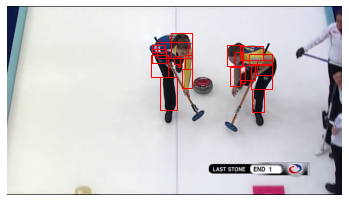

In [ ]:
im, result, _ = dataset_full[0]

show_boxes(im, result) #plotting with labels makes it impossible to see
